In [1]:
import numpy as np
from skfem import *
from skfem.models.elasticity import linear_elasticity, lame_parameters
from skfem.models.ani_elasticity import *
from skfem.visuals.matplotlib import plot, draw


input: -Gitter des 3D objekts im Mesh Format (Hürden: Wie bekomme ich die äußersten Netzpunkte von allen Seiten in Subdomains?)
      -Material des Objektes: Zu jedem Material sollen dann Elastic Modulus gegeben sein. 
      - Stärke der Kraft definieren
      - FEA von allen 6 Seiten. 
      - Ausgabe der K Matrix ob Verschiebung plastisch ist folglich Kaputt, oder nicht 

Named boundaries invalidated by a call to Mesh.refined()


Verschiebungen der oberen Knoten:
[-0.25221379 -0.25221379 -0.25221379 -0.25221379 -0.19589151 -0.19589151
 -0.19589151 -0.19589151 -0.16577389 -0.19973082 -0.19973082 -0.19973082
 -0.19973082 -0.19973082 -0.19973082 -0.19973082 -0.19973082 -0.16856876
 -0.16856876 -0.16856876 -0.16856876 -0.17174192 -0.17174192 -0.17174192
 -0.17174192 -0.20703469 -0.20703469 -0.20703469 -0.20703469 -0.20703469
 -0.20703469 -0.20703469 -0.20703469 -0.19677736 -0.19677736 -0.17334803
 -0.19677736 -0.19677736 -0.17334803 -0.19677736 -0.19677736 -0.17334803
 -0.19677736 -0.19677736 -0.17334803 -0.16643782 -0.16643782 -0.16643782
 -0.16643782 -0.17698841 -0.17698841 -0.17698841 -0.17698841 -0.17698841
 -0.17698841 -0.17698841 -0.17698841 -0.16932186 -0.16932186 -0.16932186
 -0.16932186 -0.16932186 -0.16932186 -0.16932186 -0.16932186 -0.18322142
 -0.18322142 -0.18322142 -0.18322142 -0.1741964  -0.1741964  -0.1741964
 -0.1741964  -0.1741964  -0.1741964  -0.1741964  -0.1741964  -0.16712374
 -0.16712374 -0.16

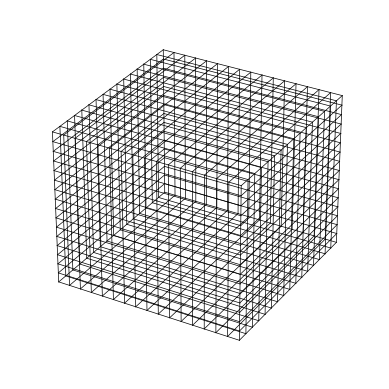

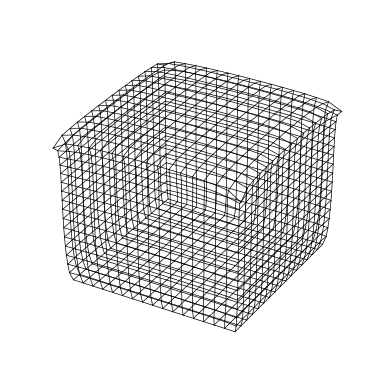

In [60]:


m = MeshHex().refined(4)
e1 = ElementHex1()

draw(m)  
e = ElementVector(e1)

ib = Basis(m, e, MappingIsoparametric(m, e1), 3) #MappingIsoparametric legt die Punkte + Element von Global auf Lokale Koordinaten zur Integrateion 

young_modulus = 31.1e9
nu = 0.35
K = asm(linear_elasticity(*lame_parameters(young_modulus,nu)), ib) #Füge die DGL und die Materialkonstanten zusammen und legt Sie auf die Basis fest
                                                            # young Modulus E = sigma/Epsilon Verhältnis zwischen Spannung und innerer Verzerrung im Material 
                                                            # poisson ratio: nu = d_x/dy Verhältnis wie weit das Material gestreckt/gestaucht wird, wenn eine Kraft auf zwei gegenseitige Seiten wirkt.


dofs = {
    'left' : ib.get_dofs(lambda x: x[0] == 0.0),        # wir legen die DOFS fest ganz genau an den Punkten, wo wir wissen, dass die linke und rechte
    'right': ib.get_dofs(lambda x: x[0] == 1.0),
    'up': ib.get_dofs(lambda x: x[2] == 1.0),              # Kante liegt. Wie kann ich das auf ein beliebiges Netz übertragen?
    'down': ib.get_dofs(lambda x: x[2] == 0.0),             # Kante liegt. Wie kann ich das auf ein beliebiges Netz übertragen?
    'front': ib.get_dofs(lambda x: x[1] == 0.0),             # Kante liegt. Wie kann ich das auf ein beliebiges Netz übertragen?
    'back': ib.get_dofs(lambda x: x[1] == 1.0)             # Kante liegt. Wie kann ich das auf ein beliebiges Netz übertragen?
}                                           

u = ib.zeros()                     # erstellen einer Matrix der Form ib bestehend aus Nullen 










Force = -20000000 #500N pro Knoten 

F = np.zeros(u.shape)
up_dofs = dofs['up'].nodal['u^3']  # Nur die Z-Komponente der oberen Knoten
F[up_dofs] = Force


# #####################

# Randbedingungen festlegen (z.B. Verschiebung an 'left' fixieren)
fixed_dofs = np.hstack([dofs['down'].all()])
u[fixed_dofs] = 0

# Randbedingungen in die Steifigkeitsmatrix integrieren
free_dofs = np.setdiff1d(np.arange(K.shape[0]), fixed_dofs)
K_free = K[free_dofs][:, free_dofs]
F_free = F[free_dofs]

# Verschiebungen lösen
u_free = solve(K_free, F_free)
u[free_dofs] = u_free

# Verschiebungen der oberen Knoten
verschiebung_oben = u[up_dofs]

print("Verschiebungen der oberen Knoten:")
print(verschiebung_oben)


# ########################



                # setzen der Anfangswerte für die Anfangsbedigungen ['u^1, u^2,u^3] gibt die Richtung der einzlenen auslenkungen an 
u[[dofs['up'].nodal['u^3']]]  = verschiebung_oben               # setzen der Anfangswerte für die Anfangsbedigungen ['u^1, u^2,u^3] gibt die Richtung der einzlenen auslenkungen an 
                                                        #sind das Kraft WERTE oder AUSLENKUNGSWERTE?



I = ib.complement_dofs(np.concatenate((dofs['up'], dofs['down'])))            # festlegen der Randbedingungnen, die Festgehalten werden sollen, also Knoten ohne DOFs
#I = ib.complement_dofs(dofsdofs['down'])          # festlegen der Randbedingungnen, die Festgehalten werden sollen, also Knoten ohne DOFs

                                                                
                                                                    #     AThe system matrix
                                                                    # b
                                                                    #     The right hand side vector, or zero if x is given, or the mass matrix
                                                                    #     for generalized eigenvalue problems.
                                                                    # x
                                                                    #     The values of the condensed degrees-of-freedom. If not given, assumed
                                                                    #     to be zero.
                                                                    # I
                                                                    #     The set of degree-of-freedom indices to include.
                                                                    # D
                                                                    #     The set of degree-of-freedom indices to dismiss.
u = solve(*condense(K, x=u, I=I))                       # er unterteilt die ib matrix in bekannte und unbekannte Kräfte und löst dann nach einandern 
                                                        # I = I beschreibt dass wir nach unbekannten auflösen D=D beschreibt nach bekannten aufzulösen 
                                                        

factor = 1                             # Übertreibungsfaktor 

m = m.translated( factor * u[ib.nodal_dofs]).draw(node_numbering=True).show()            # translate verschiebt um den Faktor Vektor
                                    #gibt alle Dofs einer base an 

# p = draw(m)
# p = draw(node_numbering=True)
# p.show()
# Was heißt .noadl['u^1]
                                             # Was heißt .noadl['u^1]
                                               # Was heißt .noadl['u^1]
                                               






In [13]:


m = MeshHex().refined(4)
e1 = ElementHex1()

 
e = ElementVector(e1)

ib = Basis(m, e, MappingIsoparametric(m, e1), 3) 

young_modulus = 31.1e9
nu = 0.35
#K = asm(linear_elasticity_anisotropic(*lame_parameters(young_modulus,nu)), ib)

@BilinearForm
def weakform(u, v, w):
    mu = 10 * (w.x[2] < 0.5) + 100 * (w.x[2] >= 0.5)
    lmbda = 10 * (w.x[2] < 0.5) + 20 * (w.x[2] >= 0.5)
    epsu = sym_grad(u)
    Cepsu = 2. * mu * epsu + lmbda * eye(trace(epsu), epsu.shape[0])
    return ddot(Cepsu, sym_grad(v))


K = asm(weakform(*lame_parameters(young_modulus, nu)), ib )



Named boundaries invalidated by a call to Mesh.refined()


AttributeError: 'BilinearForm' object has no attribute 'kernel'

<Axes3D: >

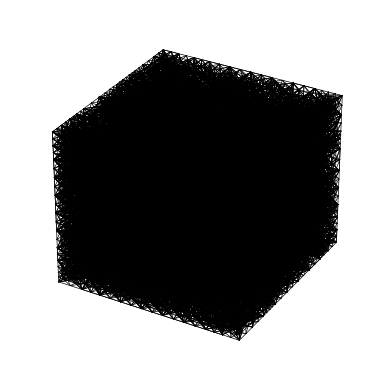

In [17]:
import numpy as np
from skfem import *
from skfem.helpers import dot, grad, div
import meshio

m = MeshTet()
m = m.load('Meshes/Cube.msh')

e =fem.ElementTetP1()

ib = Basis(m, e,MappingIsoparametric(m, e), 3)

# young_modulus = 31.1e9
# nu = 0.35
# K = asm(linear_elasticity(*lame_parameters(young_modulus,nu)), ib)

# dofs = {
#     'left' : ib.get_dofs(lambda x: x[0] == 0.0),        # wir legen die DOFS fest ganz genau an den Punkten, wo wir wissen, dass die linke und rechte
#     'right': ib.get_dofs(lambda x: x[0] == 1.0),
#     'up': ib.get_dofs(lambda x: x[2] == 1.0),              # Kante liegt. Wie kann ich das auf ein beliebiges Netz übertragen?
#     'down': ib.get_dofs(lambda x: x[2] == 0.0),             # Kante liegt. Wie kann ich das auf ein beliebiges Netz übertragen?
#     'front': ib.get_dofs(lambda x: x[1] == 0.0),             # Kante liegt. Wie kann ich das auf ein beliebiges Netz übertragen?
#     'back': ib.get_dofs(lambda x: x[1] == 1.0)             # Kante liegt. Wie kann ich das auf ein beliebiges Netz übertragen?
# }      

# u = ib.zeros()                                          # erstellen einer Matrix der Form ib bestehend aus Nullen 
# u[[dofs['up'].nodal['u^3']]]  = -0.3 

# I = ib.complement_dofs(np.concatenate((dofs['up'], dofs['down'])))            # festlegen der Randbedingungnen, die Festgehalten werden sollen, also Knoten ohne DOFs
# print(len(I))

# u = solve(*condense(K, x=u, I=I)) 
# m = m.transalted( u[ib.nodal_dofs])
# draw(m)

draw(ib)

Bounding BOX von der STL File, dann np.linspace func für Knoten im Objekt. 
Anschließend Schnittmenge vom stl file und der Bounding Box nehmen. 
Result ist dann ein equaly spaced mesh in Form für skfem 


In [ ]:

##SILVIOS LSG

import numpy as np
from skfem import *
from skfem.helpers import dot, grad, div
import meshio

m = MeshTet()
m = m.load("C:/Users/Silvio/Downloads/3D Models/Cube.msh")
# oder
#p = np.linspace(0, 1, 10)
#m = MeshTet.init_tensor(*(p,) * 3)


e = ElementTetRT1() * ElementTetP0()
basis = Basis(m, e)
fbasis = basis.boundary()


@BilinearForm
def bilinf(sigma, u, tau, v, w):
    return dot(sigma, tau) + div(sigma) * v + div(tau) * u


@LinearForm
def linf(tau, v, w):
    return (dot(tau, w.n)
            * np.sin(np.pi * w.x[1])
            * np.sin(np.pi * w.x[2])
            * np.isclose(w.x[0], 1))


A = asm(bilinf, basis)
b = asm(linf, fbasis)
x = solve(A, b)

(sigma, rtbasis), (u, ubasis) = basis.split(x)
M, X = ubasis.refinterp(u, Nrefs=0)

if __name__ == "__main__":
    M.save('output.vtk', {'sol': 

In [24]:
# Randbedingungen festlegen (z.B. Verschiebung an 'left' fixieren)
fixed_dofs = np.hstack([dofs['left'].all(), dofs['down'].all(), dofs['front'].all(), dofs['back'].all()])
u[fixed_dofs] = 0

# Randbedingungen in die Steifigkeitsmatrix integrieren
free_dofs = np.setdiff1d(np.arange(K.shape[0]), fixed_dofs)
K_free = K[free_dofs][:, free_dofs]
F_free = F[free_dofs]

# Verschiebungen lösen
u_free = solve(K_free, F_free)
u[free_dofs] = u_free

# Verschiebungen der oberen Knoten
verschiebung_oben = u[up_dofs]

print("Verschiebungen der oberen Knoten:")
print(verschiebung_oben)

Verschiebungen der oberen Knoten:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.78127978e-07
 1.27832506e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.33552259e-07 0.00000000e+00
 2.33552259e-07 9.80343912e-08 1.06720018e-07 1.06720018e-07
 1.57008770e-07 8.83661047e-08 8.83661047e-08 1.25052108e-07
 1.25052108e-07]
